# 物語の感情曲線の抽出とその極値に着目したトピックの分析


In [ ]:
import os
import pickle
import pyLDAvis.gensim
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pprint import pprint
from wordcloud import WordCloud
from tqdm import *
from labMTsimple.storyLab import *
from book import *
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.decomposition import PCA
from mvpa2.suite import SimpleSOMMapper
from pyvis.network import Network
from collections import defaultdict

sns.set(style='darkgrid')


/Volumes/macos/Users/tomoya/Documents/片寄研究室/python/topic_analyze/venv/lib/python3.7/site-packages/mvpa2/base/config.py:79: DeprecationWarning: The SafeConfigParser class has been renamed to ConfigParser in Python 3.2. This alias will be removed in future versions. Use ConfigParser directly instead.
  SafeConfigParser.__init__(self)
Failed to import duecredit due to No module named 'duecredit'
/Volumes/macos/Users/tomoya/Documents/片寄研究室/python/topic_analyze/venv/lib/python3.7/site-packages/mvpa2/misc/surfing/volume_mask_dict.py:24: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping
/Volumes/macos/Users/tomoya/Documents/片寄研究室/python/topic_analyze/venv/lib/python3.7/site-packages/mvpa2/testing/tools.py:81: DeprecationWarning: Importing from numpy.testing.decorators is deprecated since numpy 1.15.0, import from numpy.testing instead.
  from numpy.testing.decora

 * Please note: warnings are printed only once, but underlying problem might occur many times *


/Volumes/macos/Users/tomoya/Documents/片寄研究室/python/topic_analyze/venv/lib/python3.7/site-packages/mvpa2/datasets/sources/skl_data.py:32: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  argnames, varargs, varkw, defaults = inspect.getargspec(fx)
<string>:64: DeprecationWarning: invalid escape sequence \c


In [2]:
DIST = 'dist/'
DATA = 'data/'
TMP = 'tmp/'
PICKLE = 'pickle/'
CLUSTERS = 'clusters/'
TF_IDF = 'tf_idf/'
TF = 'tf/'
IDF = 'idf/'
CSV = 'csv/'
SRC = 'sources-mini.txt'
TEST = 'sources-test.txt'
WORDS_IN_WINDOW = 'words-window.txt'
WORD_DICT = 'word-dict.dict'
WORDS_CORPUS = 'words-corpus.mm'
EXCLUDE_RATE = 0.1
NUM_TOPICS = 500
labMT, labMTvector, labMTwordList = emotionFileReader(returnVector=True)


In [3]:
# sources.txtを読み込みます
infos = []
books = []
with open(DATA + SRC, 'r') as i:
    lines = i.readlines()
    for line in lines:
        line = line.strip()
        book_id, path, title = line.split(',', 2)
        infos.append([book_id, title, path])
for info in infos[:5]:
    print(info)


['215', 'The Call of the Wild', '215-cleaned.txt']
['2667', 'The Vicar of Wakefield', '2667-cleaned.txt']
['51099', 'Amadís of Gaul, Vol. II. of IV.', '51099-cleaned.txt']
['2707', 'The History Of Herodotus', '2707-cleaned.txt']
['3011', 'The Lady of the Lake', '3011-cleaned.txt']


In [4]:
def calc_happiness(window):
    return emotion(window, labMT)


In [5]:
for info in infos:
    PICKLE_FILE = TMP + PICKLE + info[0] + '.pickle'
    if os.path.exists(PICKLE_FILE):
        with open(PICKLE_FILE, 'rb') as i:
            books.append(pickle.load(i))
    else:
        book = Book(info[0], info[1], info[2])
        try:
            book.load()
            book.windowed()
            book.calc_happiness(calc_happiness)
            with open(PICKLE_FILE, 'wb') as o:
                pickle.dump(book, o)
            books.append(book)
        except BookLoadingException as err:
            pass


In [26]:
def get_min_window(book):
    happinesses = book.happinesses()
    index = happinesses.index(min(happinesses))
    return index, book.windows()[index]


def get_max_window(book):
    happinesses = book.happinesses()
    index = happinesses.index(max(happinesses))
    return index, book.windows()[index]


def tf(book, index):
    FOLDER = TMP + TF_IDF + TF + '{}/'.format(book.book_id())
    if not os.path.exists(FOLDER):
        os.makedirs(FOLDER)
    FILE = '{}.txt'.format(index)
    PATH = FOLDER + FILE
    window = book.windows()[index].split()
    if not os.path.exists(PATH):
        word_freq = defaultdict(int)
        word_set = set(window)
        for word in word_set:
            word_freq[word] = window.count(word)
        with open(PATH, 'w') as o:
            for word in word_freq:
                o.write('{} {}\n'.format(word, word_freq[word]))
    else:
        with open(PATH, 'r') as o:
            word_freq = {}
            for line in o.readlines():
                word, freq = line.split()
                word_freq[word] = int(freq)
    return word_freq


def idf(book, index, tfs):
    FOLDER = TMP + TF_IDF + IDF + '{}/'.format(book.book_id())
    if not os.path.exists(FOLDER):
        os.makedirs(FOLDER)
    FILE = '{}.txt'.format(index)
    PATH = FOLDER + FILE
    window = book.windows()[index].split()
    if not os.path.exists(PATH):
        word_freq = defaultdict(int)
        word_set = [word for word in tfs if 1 < tfs[word] < 50]
        for word in word_set:
            word_freq[word] = len(list(filter(lambda w: word in w.split(), book.windows())))
        with open(PATH, 'w') as o:
            for word in word_freq:
                o.write('{} {}\n'.format(word, word_freq[word]))
    else:
        with open(PATH, 'r') as o:
            word_freq = {}
            for line in o.readlines():
                word, freq = line.split()
                word_freq[word] = int(freq)
    return word_freq


def vectorize(book, index):
    VECTOR_CSV = TMP + TF_IDF + CSV + '{}.csv'.format(book.book_id())
    if os.path.exists(VECTOR_CSV):
        vectors = pd.read_csv(VECTOR_CSV)
    else:
        corpus = book.windows()
        vectorizer = TfidfVectorizer(token_pattern=u'(?u)\\b\\w+\\b')
        X = vectorizer.fit_transform(corpus)
        vectors = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())
        vectors.to_csv(VECTOR_CSV)
    return vectors[index:index+1]


def tf_idf(book, index):
    tfs = tf(book, index)
    idfs = idf(book, index, tfs)
    vector = [word for word in tfs 
              if 1 < tfs[word] < 50 and idfs[word] < 150]
    return vector


def remove_general_words(window, vector):
    window = window.split()
    return [word for word in window if word in vector and word in labMT]


In [27]:
def get_experimental(book):
    (index, window) = get_min_window(book)
    vector = tf_idf(book, index)
    return remove_general_words(window, vector)


In [136]:
WORDS_IN_WINDOW_PATH = TMP + WORDS_IN_WINDOW
if not os.path.exists(WORDS_IN_WINDOW_PATH):
    texts = {book.book_id(): get_experimental(book) for book in tqdm(books)}
    with open(WORDS_IN_WINDOW_PATH, 'w') as i:
        for book, words in zip(books, texts):
            i.write('{} '.format(book.book_id()))
            for word in words:
                i.write(word + ' ')
            i.write('\n')
else:
    with open(WORDS_IN_WINDOW_PATH, 'r') as i:
        texts = {}
        for line in i.readlines():
            book_id, s = line.split(None, 1)
            texts[book_id] = s.split()


In [137]:
texts = {book_id: ' '.join(texts[book_id]) for book_id in texts}
print(len(texts))


48


## Self-Organizing MapおよびWard法による階層的クラスタリング


In [138]:
examine_texts = [texts[book_id] for book_id in texts]
vectorizer = TfidfVectorizer(use_idf=True, token_pattern=u'(?u)\\b\\w+\\b')
vectors = vectorizer.fit_transform(np.array(examine_texts))
pprint(type(vectors.toarray()))


<class 'numpy.ndarray'>


In [139]:
X = vectors.toarray()
print(X.shape)
pca = PCA()
X = pca.fit_transform(X)
print(type(X))
print(X.shape)


(48, 1863)
<class 'numpy.ndarray'>
(48, 48)


In [140]:
labels = [book.title() for book in books]


In [141]:
n_rows = 32
n_cols = 32
som = SimpleSOMMapper((n_rows, n_cols), 500, learning_rate=0.05)
som.train(X)


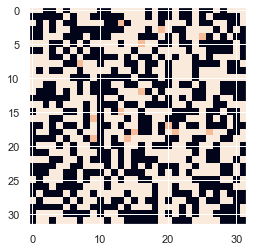

In [142]:
for vector in som.K.T:
    plt.imshow(vector)
plt.show()


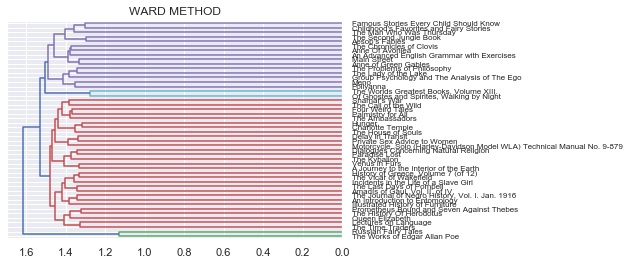

In [143]:
df = pd.DataFrame()
Z = linkage(vectors.toarray(), method='ward', metric='euclidean')
threshold = 0.93*max(Z[:, 2])
dendrogram(Z, labels=labels, orientation='left', color_threshold=threshold)
plt.title('WARD METHOD')
plt.show()


In [144]:
pprint(Z[:10])


array([[ 6.        , 29.        ,  1.13125749,  2.        ],
       [10.        , 13.        ,  1.27795957,  2.        ],
       [27.        , 39.        ,  1.29701603,  2.        ],
       [ 8.        , 44.        ,  1.30259085,  2.        ],
       [28.        , 33.        ,  1.31593908,  2.        ],
       [ 3.        , 15.        ,  1.32230933,  2.        ],
       [37.        , 43.        ,  1.32716561,  2.        ],
       [ 1.        , 35.        ,  1.3298577 ,  2.        ],
       [30.        , 31.        ,  1.33005203,  2.        ],
       [12.        , 41.        ,  1.33363318,  2.        ]])


In [145]:
c = fcluster(Z, threshold, criterion='distance')
pprint(c)


array([2, 2, 2, 2, 4, 4, 1, 2, 4, 4, 3, 2, 2, 3, 2, 2, 2, 2, 4, 2, 2, 4,
       2, 2, 4, 2, 2, 4, 2, 1, 4, 4, 2, 2, 2, 2, 4, 2, 2, 4, 2, 2, 4, 2,
       4, 2, 4, 2], dtype=int32)


In [146]:
clusters = {}
with open(TMP + CLUSTERS + 'clusters.txt', 'w') as f, \
        open(TMP + CLUSTERS + 'texts.txt', 'w') as o:
    for book, cls in zip(books, c):
        if cls not in clusters:
            clusters[cls] = []
        clusters[cls].append((book, texts[book.book_id()]))
        f.write('{} {}\n'.format(book.book_id(), cls))
        o.write('{} {}\n'.format(book.book_id(), text))


KeyError: 215

## クラスター内でのトピック分析

In [112]:
clusters = {}
books_dict = {book.book_id(): book for book in books}


In [113]:
with open(TMP + CLUSTERS + 'clusters.txt', 'r') as c, open(TMP + CLUSTERS + 'texts.txt', 'r') as t:
    for line1, line2 in zip(c.readlines(), t.readlines()):
        book_id, cls = line1.split()
        book_id, text = line2.split(None, 1)
        book_id = int(book_id)
        cls = int(cls)
        cluster = (books_dict[book_id], text.strip())
        if cls not in clusters:
            clusters[cls] = []
        clusters[cls].append(cluster)
for cls in clusters:
    print('CLASS: {}'.format(cls))
    for book, text in clusters[cls][:3]:
        print('  {}'.format(book))


CLASS: 4
  <215, The Call of the Wild, 215-cleaned.txt>
  <3011, The Lady of the Lake, 3011-cleaned.txt>
  <1450, Pollyanna, 1450-cleaned.txt>
CLASS: 2
  <2667, The Vicar of Wakefield, 2667-cleaned.txt>
  <51099, Amadís of Gaul, Vol. II. of IV., 51099-cleaned.txt>
  <2707, The History Of Herodotus, 2707-cleaned.txt>
CLASS: 1
  <2147, The Works of Edgar Allan Poe, 2147-cleaned.txt>
  <22373, Russian Fairy Tales, 22373-cleaned.txt>
CLASS: 3
  <51038, Of Ghostes and Spirites, Walking by Night, 51038-cleaned.txt>
  <13620, The Worlds Greatest Books, Volume XIII., 13620-cleaned.txt>


In [131]:
ex_texts = {cls: [t for book, t in clusters[cls]] for cls in clusters}
for cls in ex_texts:
    print(' '.join(ex_texts[cls][0].split()[:3]))


buried agony torn
wicked compassion support
willing accepted information
hell raised fit


## WordCloudによる可視化


In [132]:
cloud_texts = {cls: ' '.join(ex_texts[cls]) for cls in ex_texts}


4
2
1
3


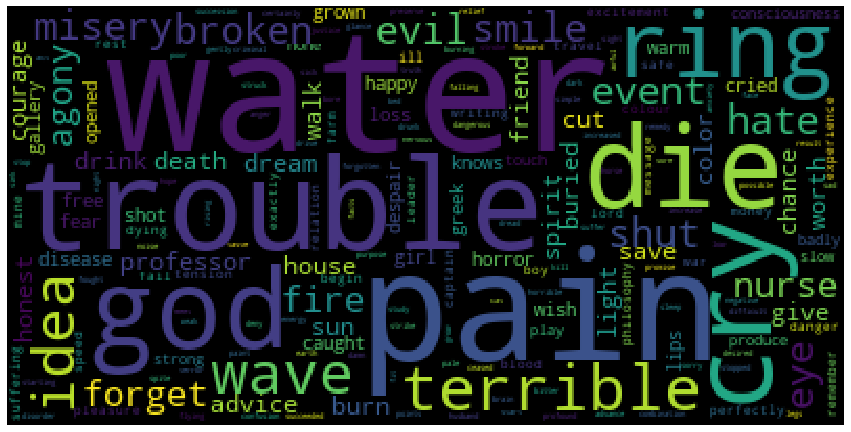

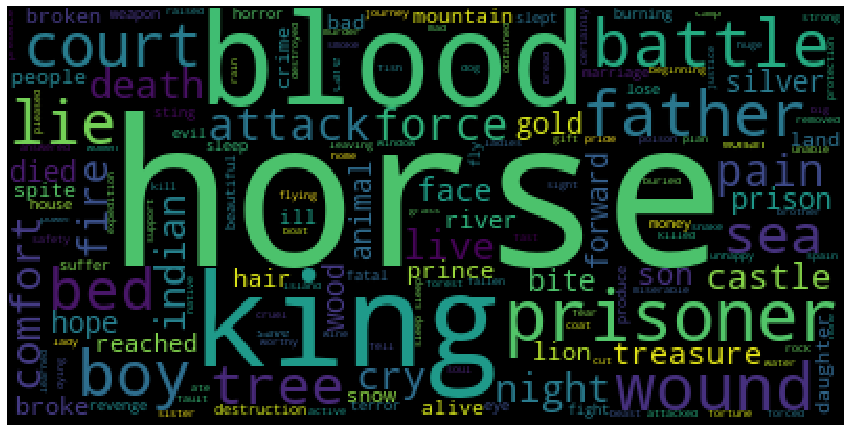

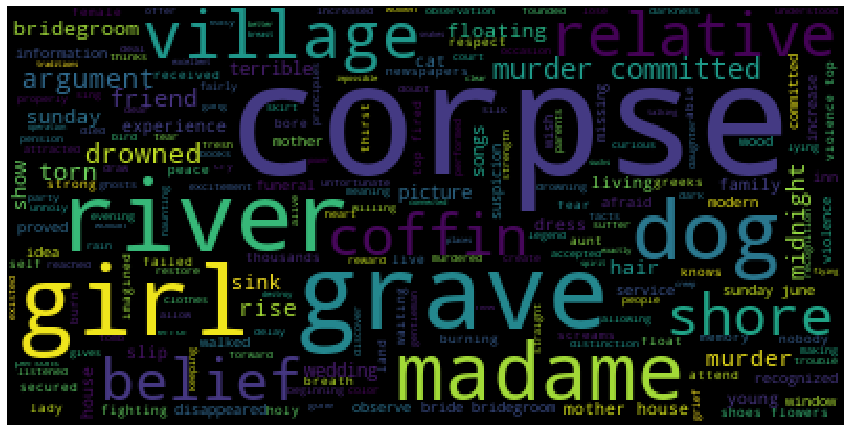

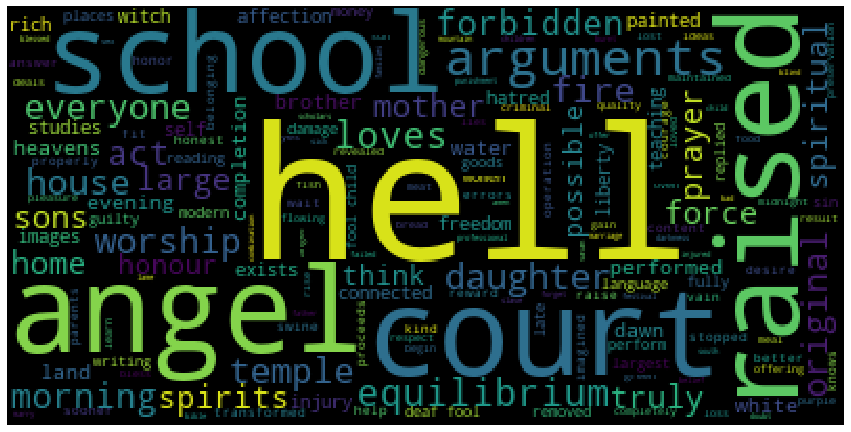

In [134]:
WORD_CLOUD_PATH = DIST + 'word-cloud/'
if not os.path.exists(WORD_CLOUD_PATH):
    os.makedirs(WORD_CLOUD_PATH)
for cls in cloud_texts:
    print(cls)
    wordcloud = WordCloud().generate(cloud_texts[cls])

    plt.figure(figsize=(15,12))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.savefig(WORD_CLOUD_PATH + '{}.png'.format(cls))


## 共起ネットワークを構築する


In [ ]:
def generate_network(df):
    net = Network(height="1000px", width="95%", bgcolor="#FFFFFF", font_color="black", notebook=True)
    print(df)
    return net


In [ ]:
test_df = pd.DataFrame([[1.2, 2.3, 3.1, 0.0], [1.2, 2.3, 3.1, 1.4]], columns=['hello', 'i', 'happy', 'this'])
net = generate_network(test_df)
